# Quantum state tomography of Rydberg ground states

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from mpi4py import MPI
import netket as nk
import warnings
warnings.filterwarnings('ignore')

In [2]:
""" Generate the square lattice structures """
def buildlattice(Lx,Ly):
    def coord_to_site(Ly,x,y):
        return Ly*x+y
    nn = []  
    nnn = []
    nnnn = []
    for x in range(Lx):
        for y in range(Ly-1):
            nn.append([coord_to_site(Ly,x,y),coord_to_site(Ly,x,y+1)])
    for y in range(Ly):
        for x in range(Lx-1):
            nn.append([coord_to_site(Ly,x,y),coord_to_site(Ly,x+1,y)])
    
    for y in range(Ly-1):
        for x in range(Lx-1):
            nnn.append([coord_to_site(Ly,x,y),coord_to_site(Ly,x+1,y+1)])
            nnn.append([coord_to_site(Ly,x+1,y),coord_to_site(Ly,x,y+1)])
    
    for y in range(Ly):
        for x in range(Lx-2):
            nnnn.append([coord_to_site(Ly,x,y),coord_to_site(Ly,x+2,y)])
    for y in range(Ly-2):
        for x in range(Lx):
            nnnn.append([coord_to_site(Ly,x,y),coord_to_site(Ly,x,y+2)])
    return nn,nnn,nnnn

In [3]:
def generatehamiltonian(hilbert,Lx,Ly,V,Omega,delta):
    N = Lx * Ly
    nn,nnn,nnnn = buildlattice(Lx,Ly)
    P   = np.asarray([[0,0],[0,1]])
    PP  = np.kron(P,P) 
    sx = np.asarray([[0,1],[1,0]])
    
    H = nk.operator.LocalOperator(hilbert)
    # Transverse field 
    for j in range(N):
        localop = -0.5 * Omega * sx
        H += nk.operator.LocalOperator(hilbert,localop,[j])
    # Chemical potential
    for j in range(N):
        localop = -delta * P
        H += nk.operator.LocalOperator(hilbert,localop,[j])
    
    # NN interactions
    for bond in nn:
        localop = V * PP
        H += nk.operator.LocalOperator(hilbert,localop,[bond[0],bond[1]])
    for bond in nnn:
        localop = (V/8.0) * PP
        H += nk.operator.LocalOperator(hilbert,localop,[bond[0],bond[1]])
    for bond in nnnn:
        localop = (V/64.0) * PP
        H += nk.operator.LocalOperator(hilbert,localop,[bond[0],bond[1]])

    return H

In [4]:
def LoadData(hilbert,path_to_samples):
    training_samples = []
    training_bases = []
    training_samples = np.loadtxt(path_to_samples)

    rotations = []
    for i in range(len(training_samples)):
        training_bases.append(0)
        rotations.append(nk.operator.LocalOperator(hilbert, 1.0))

    return tuple(rotations), np.asarray(training_samples), np.asarray(training_bases)

In [5]:
Lx = 4
Ly = 4
N = Lx * Ly
alpha = 1
n_samples_rbm = 2000
n_samples_data = 500
epochs = 1000
lr = 0.01
V = 7.0
Omega = 1.0
delta = 1.0
dmrg_energy = -0.45776822

rbm_energy = []

graph = nk.graph.Hypercube(length=Lx, n_dim=2,pbc=False)
hilbert = nk.hilbert.Qubit(graph=graph)

# Load the data
dataName = "../data/tomography/rydberg/data_rydberg_4x4_delta="
dataName += str(delta)
dataName += ".txt"

rotations, training_samples, training_bases = LoadData(hilbert,dataName)

# Machine
ma = nk.machine.RbmSpinReal(hilbert=hilbert, alpha=alpha)
ma.init_random_parameters(seed=1234, sigma=0.01)

# Sampler
sa = nk.sampler.MetropolisLocal(machine=ma)    

#op = nk.optimizer.AdaDelta(rho=0.95,epscut = 1.0e-7)
op = nk.optimizer.RmsProp(learning_rate=lr,beta=0.9,epscut = 1.0e-6)

# Quantum State Reconstruction
qst = nk.Qsr(
    sampler=sa,
    optimizer=op,
    n_samples_data=n_samples_data,
    n_samples=n_samples_rbm,
    rotations=rotations,
    samples=training_samples,
    bases=training_bases,
    sr = None)

H = generatehamiltonian(hilbert,Lx,Ly,V,Omega,float(delta)) 
qst.add_observable(H,"H")

print("Running QST for delta =",delta) 
for ep in qst.iter(epochs+1, 10):
    obs = qst.get_observable_stats()
    energy = (obs["H"].mean.real)/float(N)
    if (ep%100==0):
        print("Epoch: %1d" % (ep),end="  ")
        print("<H> = %.8f" % energy,end=" | ")
        print("(DMRG = %.8f)" % dmrg_energy)
    rbm_energy.append(energy)

Running QST for delta = 1.0
Epoch: 0  <H> = 1.84829682 | (DMRG = -0.45776822)
Epoch: 100  <H> = -0.32111179 | (DMRG = -0.45776822)
Epoch: 200  <H> = -0.36534478 | (DMRG = -0.45776822)
Epoch: 300  <H> = -0.38362597 | (DMRG = -0.45776822)
Epoch: 400  <H> = -0.40856511 | (DMRG = -0.45776822)
Epoch: 500  <H> = -0.42492725 | (DMRG = -0.45776822)
Epoch: 600  <H> = -0.43573942 | (DMRG = -0.45776822)
Epoch: 700  <H> = -0.44134153 | (DMRG = -0.45776822)
Epoch: 800  <H> = -0.44144990 | (DMRG = -0.45776822)
Epoch: 900  <H> = -0.44545500 | (DMRG = -0.45776822)
Epoch: 1000  <H> = -0.44735577 | (DMRG = -0.45776822)


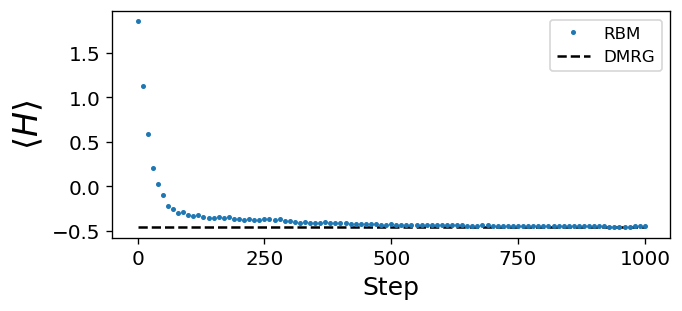

In [13]:
fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

plt.plot(rbm_energy,marker='o',markersize=2,linewidth=0.0,label="RBM")
plt.hlines(dmrg_energy,0,epochs//10,linestyle="--",label="DMRG")
plt.xticks([0,25,50,75,100],[0,250,500,750,1000],fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle$",fontsize=20)
plt.legend(loc="best")

plt.show()